# Spotify Song Popularity: Predictive Modeling

## Navigation
- [Setup & Data Loading](#setup)
- [Model Formulation Strategy](#formulation)
- [Model Training & Comparison](#training)
- [Cross-Validation](#cross-validation)
- [Model Interpretation](#interpretation)
- [Final Results](#results)
- [Conclusions](#conclusions)

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from patsy import dmatrices
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Cleaned Data

In [2]:
sys.path.append('../src')
from data_loader import load_log_transformed_data

log_df = load_log_transformed_data()

print(f"Dataset loaded: {log_df.shape}")
print(f"Target variable: pop_log")

Dataset loaded: (25190, 17)
Target variable: pop_log


## Prepare Data for Modeling

### Create Generic Column Names

For model formulation, we'll use generic names (x01, x02, ..., y) to simplify formula syntax.


In [3]:
# Extract categorical and numeric features
cat_vars = log_df.select_dtypes('category').columns.tolist()
num_vars = log_df.select_dtypes('number').columns.tolist()

# Remove target from numeric features
num_vars.remove('pop_log')

# Create modeling dataframe with generic names
lm_df = pd.concat([log_df[cat_vars], log_df[num_vars], log_df[['pop_log']]], axis=1)

# Generate generic column names
old_cols = lm_df.columns.tolist()
new_cols = [f'x{i:02d}' for i in range(1, len(old_cols))] + ['y']

# Create mapping for reference
col_map = pd.DataFrame({
    'original_name': old_cols,
    'model_name': new_cols
})

# Rename columns
lm_df.columns = new_cols

print("\nColumn Mapping:")
print(col_map)


Column Mapping:
           original_name model_name
0         playlist_genre        x01
1                    key        x02
2                   mode        x03
3           release_year        x04
4          release_month        x05
5                decades        x06
6           danceability        x07
7                 energy        x08
8               loudness        x09
9                valence        x10
10                 tempo        x11
11           duration_ms        x12
12       speechiness_log        x13
13      acousticness_log        x14
14  instrumentalness_log        x15
15          liveness_log        x16
16               pop_log          y


## Model Formulation Strategy

### Models to Test

We'll test 8 increasingly complex models:

1. **Baseline (Intercept-only)**: `y ~ 1`
   - Predicts mean popularity for all songs
   
2. **Categorical only**: `y ~ x01 + x02 + x03 + x05 + x06`
   - Genre, key, mode, release_month, decades
   
3. **Continuous only**: `y ~ x07 + x08 + ... + x16`
   - All audio features (linear)
   
4. **All linear additive**: `y ~ x01 + x02 + ... + x16`
   - All features, no interactions
   
5. **Continuous pairwise interactions**: `y ~ (x07 + x08 + ... + x16)²`
   - All 2-way interactions between audio features
   
6. **All pairwise interactions**: `y ~ (x01 + x02 + ... + x16)²`
   - Full interaction model (likely overfit)
   
7. **Derived features**: `y ~ all_linear + sqrt(x13) + sqrt(x14) + x15² + ...`
   - Based on EDA observations of non-linear relationships
   
8. **Categorical + continuous interactions + derived**: Complex model balancing performance and interpretability


In [4]:
formula_list = [
    'y~1',  # Model 1: Baseline
    'y~x01 + x02 + x03 + x05 + x06',  # Model 2: Categorical only
    'y~x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16',  # Model 3: Continuous only
    'y~x01 + x02 + x03 + x05 + x06 + x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16',  # Model 4: All linear
    'y~(x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16)**2',  # Model 5: Continuous interactions
    'y~(x01 + x02 + x03 + x05 + x06 + x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16)**2',  # Model 6: All interactions
    'y~x01 + x02 + x03 + x05 + x06 + x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + np.power(x09, 2) + np.power(x12, 2) + np.sqrt(x13) + np.sqrt(x14) + np.power(x15, 2) + np.sqrt(x16)',  # Model 7: Derived features
    'y~((x01 + x02 + x03 + x05 + x06) + (x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16)**2) + (np.power(x07, 2) + np.power(x08, 2) + np.power(x09, 2) + np.power(x10, 2) + np.power(x11, 2) + np.power(x12, 2) + np.sqrt(x13) + np.sqrt(x14) + np.power(x15, 2) + np.sqrt(x16))'  # Model 8: Complex
]

print(f"Total models to test: {len(formula_list)}")

Total models to test: 8


## Model Training & Comparison

### Define Helper Functions

In [5]:
def fit_and_assess_ols(mod_id, formula, data):
    """Fit OLS model and return performance metrics."""
    model = smf.ols(formula=formula, data=data).fit()
    
    return pd.DataFrame({
        'model_id': mod_id,
        'formula': formula,
        'num_coefs': len(model.params),
        'R_squared': model.rsquared,
        'RMSE': np.sqrt((model.resid ** 2).mean())
    }, index=[0])


def extract_significant_coefs(model, formula, alpha=0.05):
    """Extract statistically significant coefficients."""
    coef_df = pd.DataFrame({
        'coef_name': model.params.index,
        'coef_value': model.params.values,
        'std_err': model.bse.values,
        'p_value': model.pvalues.values,
        'significant': model.pvalues.values < alpha
    })
    
    # Sort by absolute coefficient value
    coef_df = coef_df.reindex(coef_df['coef_value'].abs().sort_values(ascending=False).index)
    
    return coef_df[coef_df['significant']].reset_index(drop=True)


### Fit All Models

In [6]:
%%time

ols_results = []

for i, formula in enumerate(formula_list, start=1):
    print(f'Fitting Model {i}...')
    try:
        ols_results.append(fit_and_assess_ols(i, formula, lm_df))
    except Exception as e:
        print(f'  ⚠ Model {i} failed: {str(e)}')

ols_results_df = pd.concat(ols_results, ignore_index=True)
print("\n✓ All models fitted")

Fitting Model 1...
Fitting Model 2...
Fitting Model 3...
Fitting Model 4...
Fitting Model 5...
Fitting Model 6...
Fitting Model 7...
Fitting Model 8...

✓ All models fitted
CPU times: user 21.7 s, sys: 4.55 s, total: 26.2 s
Wall time: 2.81 s


### Compare Model Performance on Training Data

In [7]:
# Display results
print("\nModel Performance (Training Data):")
print(ols_results_df.sort_values('R_squared', ascending=False).to_string(index=False))


Model Performance (Training Data):
 model_id                                                                                                                                                                                                                                                                                formula  num_coefs     R_squared     RMSE
        6                                                                                                                                                                                         y~(x01 + x02 + x03 + x05 + x06 + x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16)**2        895  1.459888e-01 2.071874
        8 y~((x01 + x02 + x03 + x05 + x06) + (x07 + x08 + x09 + x10 + x11 + x12 + x13 + x14 + x15 + x16)**2) + (np.power(x07, 2) + np.power(x08, 2) + np.power(x09, 2) + np.power(x10, 2) + np.power(x11, 2) + np.power(x12, 2) + np.sqrt(x13) + np.sqrt(x14) + np.power(x15, 2) + np.sqrt(x16))        101  8.919226e-02 2.13

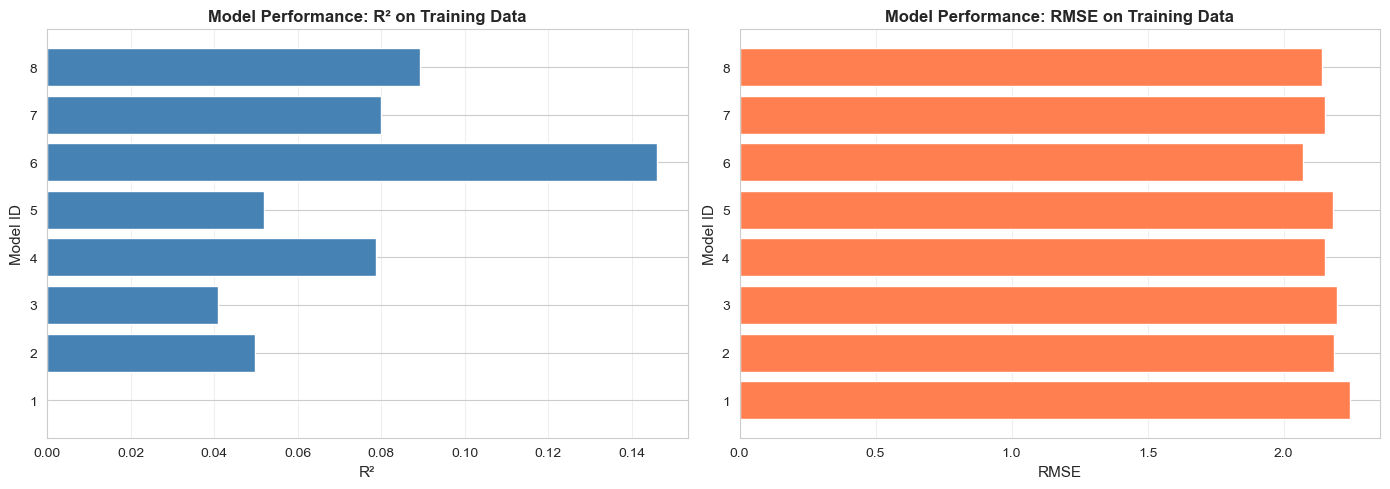

In [8]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R-squared comparison
axes[0].barh(ols_results_df['model_id'].astype(str), ols_results_df['R_squared'], color='steelblue')
axes[0].set_xlabel('R²', fontsize=11)
axes[0].set_ylabel('Model ID', fontsize=11)
axes[0].set_title('Model Performance: R² on Training Data', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# RMSE comparison
axes[1].barh(ols_results_df['model_id'].astype(str), ols_results_df['RMSE'], color='coral')
axes[1].set_xlabel('RMSE', fontsize=11)
axes[1].set_ylabel('Model ID', fontsize=11)
axes[1].set_title('Model Performance: RMSE on Training Data', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

**Observation:** Model 6 (all interactions) performs best on training data (R² ≈ 0.15) but has 895 coefficients - likely severely overfit.

## Detailed Analysis of Key Models

### Model 4: All Linear Additive Features (Baseline)

In [9]:
# Fit Model 4
mod_all_linear = smf.ols(formula=formula_list[3], data=lm_df).fit()

print(f"Model 4 Summary:")
print(f"  R²: {mod_all_linear.rsquared:.4f}")
print(f"  RMSE: {np.sqrt((mod_all_linear.resid**2).mean()):.4f}")
print(f"  Coefficients: {len(mod_all_linear.params)}")

Model 4 Summary:
  R²: 0.0787
  RMSE: 2.1520
  Coefficients: 46



Significant coefficients: 26

Top 10 Most Important Features:
      coef_name  coef_value       p_value
0           x08   -1.573473  4.465296e-36
1   x01[T.rock]    0.710877  9.925859e-34
2           x07    0.681889  6.308831e-09
3           x14    0.601489  8.260889e-10
4    x01[T.pop]    0.587619  1.289444e-31
5           x16   -0.489499  3.284971e-05
6  x01[T.latin]    0.480321  3.709382e-20
7     x05[T.11]    0.455067  1.394338e-16
8    x01[T.rap]    0.441505  1.235935e-17
9     x05[T.12]    0.423870  5.410996e-12


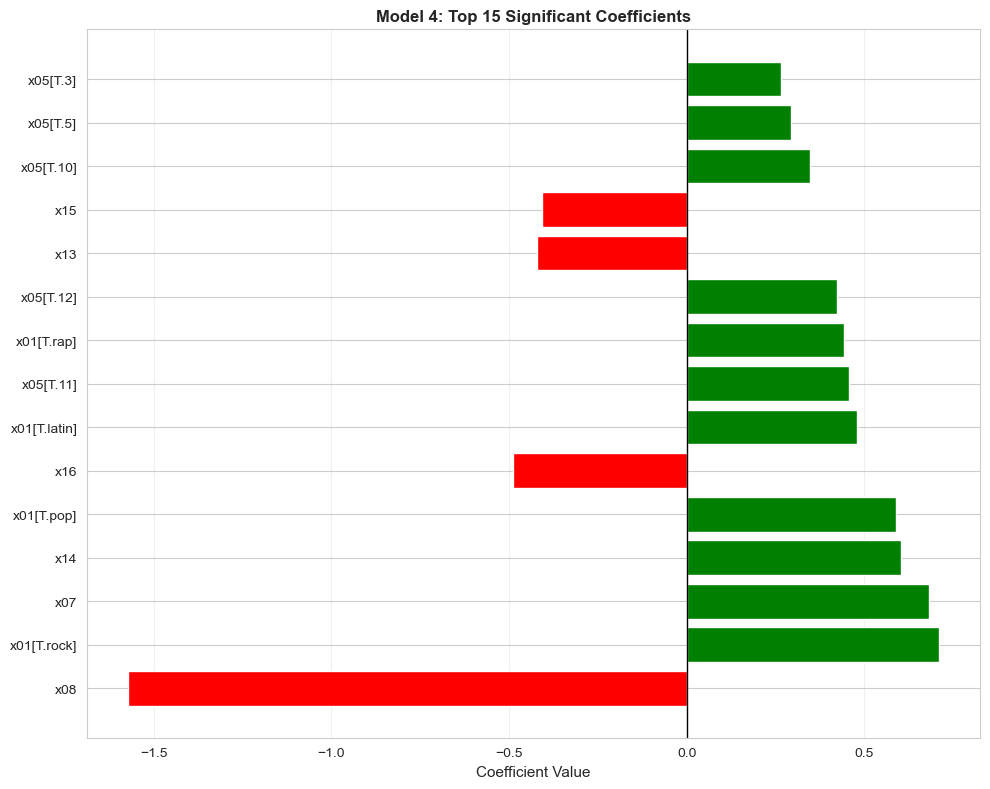

In [10]:
# Extract significant coefficients
sig_coefs_m4 = extract_significant_coefs(mod_all_linear, formula_list[3])
print(f"\nSignificant coefficients: {len(sig_coefs_m4)}")
print("\nTop 10 Most Important Features:")
print(sig_coefs_m4.head(10)[['coef_name', 'coef_value', 'p_value']])

# Coefficient plot
fig, ax = plt.subplots(figsize=(10, 8))
top_coefs = sig_coefs_m4.head(15)
colors = ['red' if val < 0 else 'green' for val in top_coefs['coef_value']]

ax.barh(range(len(top_coefs)), top_coefs['coef_value'], color=colors)
ax.set_yticks(range(len(top_coefs)))
ax.set_yticklabels(top_coefs['coef_name'])
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('Model 4: Top 15 Significant Coefficients', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=1)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Key Findings (Model 4):**
- **Energy (x08)**: Strong negative effect (-1.57) - higher energy = lower popularity
- **Genre (x01)**: Rock has largest positive effect (+0.71)
- **Danceability (x07)**: Positive effect (+0.68)
- **Acousticness (x14)**: Positive effect (+0.60)

### Model 6: All Interactions (Overfit Check)

In [11]:
# Fit Model 6
mod_all_interactions = smf.ols(formula=formula_list[5], data=lm_df).fit()

print(f"Model 6 Summary:")
print(f"  R²: {mod_all_interactions.rsquared:.4f}")
print(f"  RMSE: {np.sqrt((mod_all_interactions.resid**2).mean()):.4f}")
print(f"  Coefficients: {len(mod_all_interactions.params)}")

Model 6 Summary:
  R²: 0.1460
  RMSE: 2.0719
  Coefficients: 895


In [12]:
# Extract significant coefficients
sig_coefs_m6 = extract_significant_coefs(mod_all_interactions, formula_list[5])
print(f"\nSignificant coefficients: {len(sig_coefs_m6)}")
print("\nTop 5 Most Important Interactions:")
print(sig_coefs_m6.head(5)[['coef_name', 'coef_value', 'p_value']])


Significant coefficients: 122

Top 5 Most Important Interactions:
                  coef_name  coef_value   p_value
0           x06[T.1980]:x13   -5.437589  0.016050
1  x01[T.latin]:x06[T.1970]    4.629698  0.008359
2    x01[T.pop]:x06[T.1970]    3.672137  0.002877
3               x06[T.1970]   -3.588006  0.024425
4                x01[T.pop]    3.207750  0.000008


**Warning:** Model 6 has 895 coefficients and 122 significant features - clear signs of overfitting. We expect this model to perform poorly on test data.

### Model 8: Balanced Complexity

In [13]:
# Fit Model 8
mod_complex = smf.ols(formula=formula_list[7], data=lm_df).fit()

print(f"Model 8 Summary:")
print(f"  R²: {mod_complex.rsquared:.4f}")
print(f"  RMSE: {np.sqrt((mod_complex.resid**2).mean()):.4f}")
print(f"  Coefficients: {len(mod_complex.params)}")

Model 8 Summary:
  R²: 0.0892
  RMSE: 2.1397
  Coefficients: 101


In [14]:
# Extract significant coefficients
sig_coefs_m8 = extract_significant_coefs(mod_complex, formula_list[7])
print(f"\nSignificant coefficients: {len(sig_coefs_m8)}")
print("\nTop 10 Most Important Features:")
print(sig_coefs_m8.head(10)[['coef_name', 'coef_value', 'p_value']])


Significant coefficients: 39

Top 10 Most Important Features:
          coef_name  coef_value   p_value
0         Intercept    3.748000  0.044343
1               x07   -3.352033  0.020936
2           x14:x16    2.887100  0.000762
3               x15   -2.695722  0.007677
4           x07:x16    2.497928  0.005703
5               x14   -2.265770  0.024566
6  np.power(x15, 2)    1.942303  0.002805
7               x10    1.670787  0.042001
8           x07:x10    1.648553  0.003022
9           x07:x14    1.497757  0.044319


## Visualize Predictions

### Predicted vs Observed (Training Data)

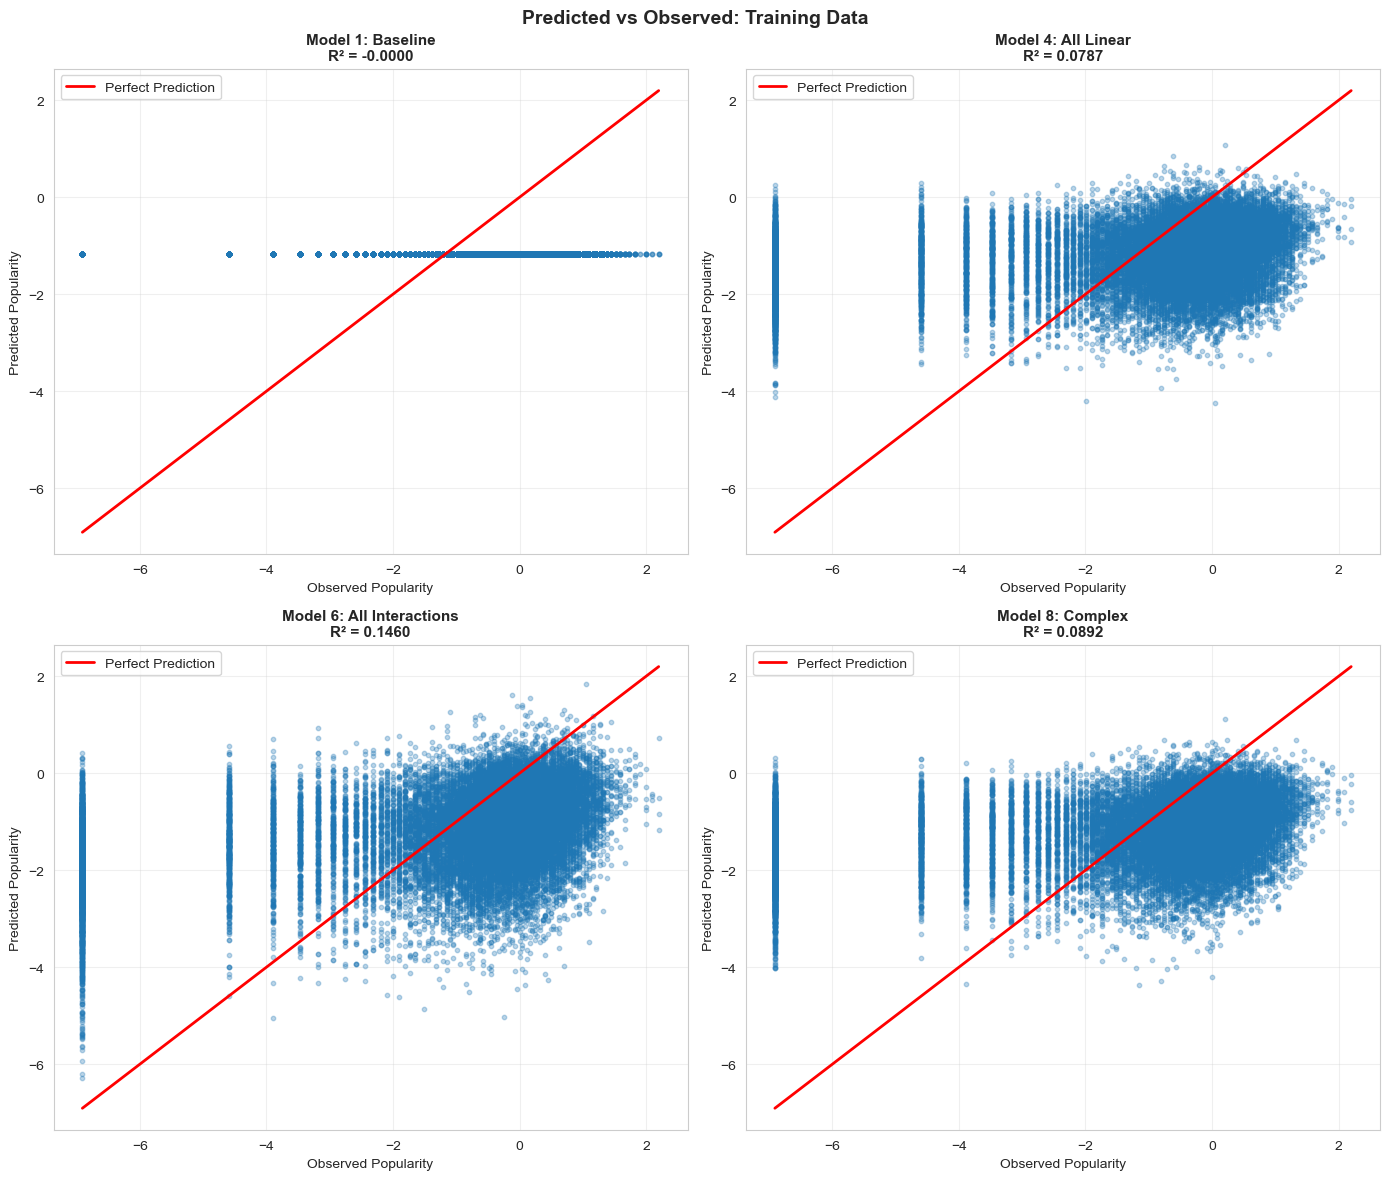

In [15]:
# Select models to visualize
models_to_viz = [
    (1, 'y~1', 'Baseline'),
    (4, formula_list[3], 'All Linear'),
    (6, formula_list[5], 'All Interactions'),
    (8, formula_list[7], 'Complex')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (model_id, formula, name) in enumerate(models_to_viz):
    # Fit model
    model = smf.ols(formula=formula, data=lm_df).fit()
    y_pred = model.predict(lm_df)
    y_true = lm_df['y']
    
    # Plot
    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    axes[idx].plot([y_true.min(), y_true.max()], 
                   [y_true.min(), y_true.max()], 
                   'r-', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Observed Popularity', fontsize=10)
    axes[idx].set_ylabel('Predicted Popularity', fontsize=10)
    axes[idx].set_title(f'Model {model_id}: {name}\nR² = {model.rsquared:.4f}', 
                        fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle('Predicted vs Observed: Training Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Observation:** Even the best training model (Model 6) shows high scatter around the diagonal, indicating weak predictive power.

## Cross-Validation

### Setup K-Fold Cross-Validation

In [16]:
kf = KFold(n_splits=5, random_state=121, shuffle=True)

def cross_validate_model(model_id, formula, data, cv):
    """Perform cross-validation and return metrics."""
    # Create design matrices
    y, X = dmatrices(formula, data=data)
    
    # Create pipeline with standardization
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    
    # Cross-validation scores
    r2_scores = cross_val_score(pipe, X, y.ravel(), cv=cv, scoring='r2')
    rmse_scores = -cross_val_score(pipe, X, y.ravel(), cv=cv, scoring='neg_root_mean_squared_error')
    
    # Create results dataframe
    results = pd.DataFrame({
        'model_id': model_id,
        'formula': formula,
        'fold': range(1, len(r2_scores) + 1),
        'R_squared': r2_scores,
        'RMSE': rmse_scores,
        'num_coefs': X.shape[1]
    })
    
    return results

### Run Cross-Validation on All Models

In [17]:
%%time

# Test models 1, 2, 3, 4, 6, 7, 8 (skip 5 to save time, it's similar to 6)
models_to_cv = [1, 2, 3, 4, 6, 7, 8]

cv_results = []

for model_id in models_to_cv:
    print(f'Cross-validating Model {model_id}...')
    try:
        cv_results.append(cross_validate_model(model_id, formula_list[model_id-1], lm_df, kf))
    except Exception as e:
        print(f'  ⚠ Model {model_id} failed CV: {str(e)}')

cv_results_df = pd.concat(cv_results, ignore_index=True)
print("\n✓ Cross-validation complete")

Cross-validating Model 1...
Cross-validating Model 2...
Cross-validating Model 3...
Cross-validating Model 4...
Cross-validating Model 6...
Cross-validating Model 7...
Cross-validating Model 8...

✓ Cross-validation complete
CPU times: user 1min 9s, sys: 26.9 s, total: 1min 36s
Wall time: 10 s


### Cross-Validation Results

In [18]:
# Calculate mean performance across folds
cv_summary = cv_results_df.groupby('model_id').agg({
    'R_squared': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'num_coefs': 'first'
}).round(4)

cv_summary.columns = ['R²_mean', 'R²_std', 'RMSE_mean', 'RMSE_std', 'num_coefs']
print("\nCross-Validation Summary (5-Fold):")
print(cv_summary.sort_values('R²_mean', ascending=False))


Cross-Validation Summary (5-Fold):
               R²_mean        R²_std     RMSE_mean      RMSE_std  num_coefs
model_id                                                                   
8         7.970000e-02  1.260000e-02  2.150400e+00  2.240000e-02        101
7         7.460000e-02  1.290000e-02  2.156400e+00  2.350000e-02         52
4         7.400000e-02  1.300000e-02  2.157100e+00  2.300000e-02         46
2         4.630000e-02  6.500000e-03  2.189200e+00  2.390000e-02         36
3         3.940000e-02  9.300000e-03  2.197000e+00  1.940000e-02         11
1        -2.000000e-04  2.000000e-04  2.242000e+00  2.400000e-02          1
6        -1.259021e+21  2.757282e+21  4.056037e+10  7.805097e+10        895


### Visualize Cross-Validation Performance

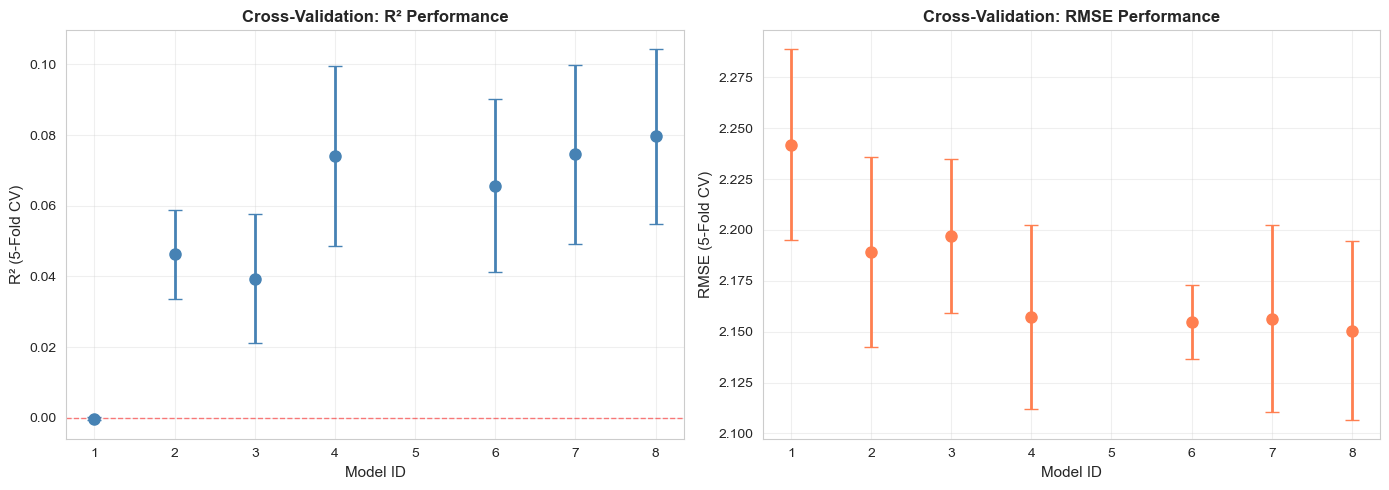

In [19]:
# Filter out catastrophic failures (Model 6)
cv_plot_df = cv_results_df[cv_results_df['R_squared'] > -100].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² with error bars
model_means = cv_plot_df.groupby('model_id')['R_squared'].mean()
model_stds = cv_plot_df.groupby('model_id')['R_squared'].std()

axes[0].errorbar(
    model_means.index, 
    model_means.values,
    yerr=model_stds.values * 1.96,  # 95% CI
    fmt='o',
    markersize=8,
    capsize=5,
    linewidth=2,
    color='steelblue'
)
axes[0].set_xlabel('Model ID', fontsize=11)
axes[0].set_ylabel('R² (5-Fold CV)', fontsize=11)
axes[0].set_title('Cross-Validation: R² Performance', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

# RMSE with error bars
rmse_means = cv_plot_df.groupby('model_id')['RMSE'].mean()
rmse_stds = cv_plot_df.groupby('model_id')['RMSE'].std()

axes[1].errorbar(
    rmse_means.index,
    rmse_means.values,
    yerr=rmse_stds.values * 1.96,  # 95% CI
    fmt='o',
    markersize=8,
    capsize=5,
    linewidth=2,
    color='coral'
)
axes[1].set_xlabel('Model ID', fontsize=11)
axes[1].set_ylabel('RMSE (5-Fold CV)', fontsize=11)
axes[1].set_title('Cross-Validation: RMSE Performance', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Critical Observations:**
- **Model 6 failed catastrophically** on CV (extreme negative R²) - severe overfitting confirmed
- **Model 8** performs best on test data (R² ≈ 0.080)
- **Model 4** performs nearly as well (R² ≈ 0.074) with half the complexity
- Error bars overlap between Models 4, 7, and 8

## Model Selection

### Compare Top Candidates

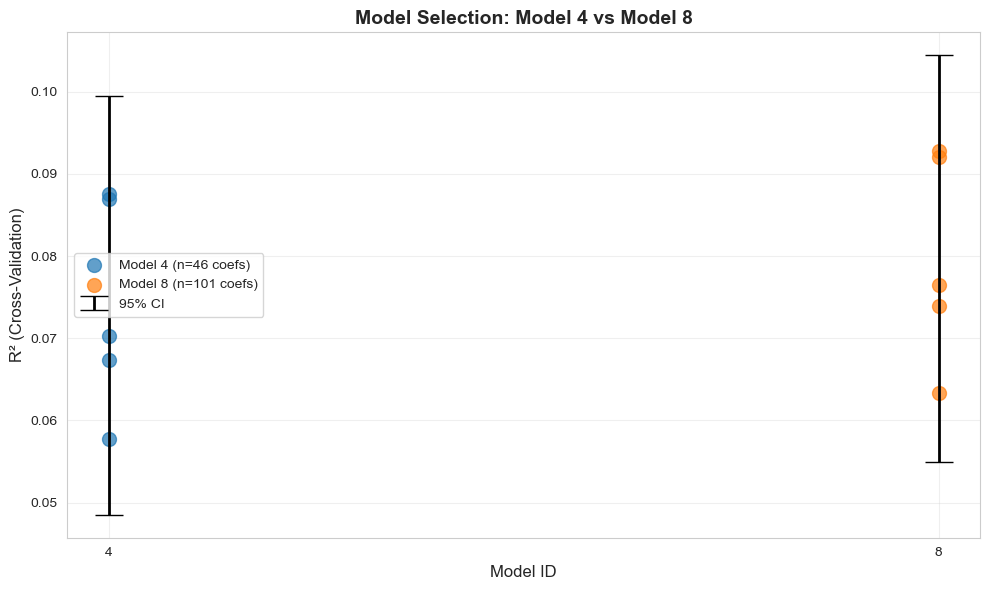


Model Comparison:
Model 4: R² = 0.0740 ± 0.0130
Model 8: R² = 0.0797 ± 0.0126


In [20]:
# Focus on Models 4 and 8
top_models = cv_results_df[cv_results_df['model_id'].isin([4, 8])]

fig, ax = plt.subplots(figsize=(10, 6))

for model_id in [4, 8]:
    model_data = top_models[top_models['model_id'] == model_id]
    ax.scatter(
        [model_id] * len(model_data),
        model_data['R_squared'],
        s=100,
        alpha=0.7,
        label=f'Model {model_id} (n={model_data["num_coefs"].iloc[0]} coefs)'
    )

ax.errorbar(
    [4, 8],
    top_models.groupby('model_id')['R_squared'].mean(),
    yerr=top_models.groupby('model_id')['R_squared'].std() * 1.96,
    fmt='none',
    elinewidth=2,
    capsize=10,
    color='black',
    label='95% CI'
)

ax.set_xlabel('Model ID', fontsize=12)
ax.set_ylabel('R² (Cross-Validation)', fontsize=12)
ax.set_title('Model Selection: Model 4 vs Model 8', fontsize=14, fontweight='bold')
ax.set_xticks([4, 8])
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Statistical comparison
print("\nModel Comparison:")
print(f"Model 4: R² = {top_models[top_models['model_id']==4]['R_squared'].mean():.4f} "
      f"± {top_models[top_models['model_id']==4]['R_squared'].std():.4f}")
print(f"Model 8: R² = {top_models[top_models['model_id']==8]['R_squared'].mean():.4f} "
      f"± {top_models[top_models['model_id']==8]['R_squared'].std():.4f}")

**Decision:** 
> **Model 4 is selected** as the final model. While Model 8 has slightly higher R² (0.080 vs 0.074), the 95% confidence intervals overlap and Model 4 is much simpler (46 vs 101 coefficients). Following Occam's Razor, we choose the simpler model.

## Model Interpretation

### Final Model: Model 4 (All Linear Additive)

**Model Formula:** `y ~ genre + key + mode + release_month + decades + danceability + energy + loudness + valence + tempo + duration + speechiness_log + acousticness_log + instrumentalness_log + liveness_log`

**Performance:**
- Training R²: 0.0787
- Cross-Validation R²: 0.0740 ± 0.0122
- RMSE: 2.152
- Coefficients: 46 (26 significant)

### Most Important Predictors

In [21]:
# Refit final model
final_model = smf.ols(formula=formula_list[3], data=lm_df).fit()
final_sig_coefs = extract_significant_coefs(final_model, formula_list[3])

# Map back to original names (handles categorical dummy variables)
def map_coef_name(coef_name, col_map_dict):
    """Map model coefficient names back to original feature names."""
    # Direct match
    if coef_name in col_map_dict:
        return col_map_dict[coef_name]
    
    # Categorical dummy variables (e.g., x01[T.rock] -> playlist_genre[T.rock])
    if '[' in coef_name:
        base_var = coef_name.split('[')[0]
        category = coef_name.split('[')[1]
        if base_var in col_map_dict:
            return f"{col_map_dict[base_var]}[{category}"
    
    return coef_name  # Return as-is if no mapping found

mapping_dict = dict(zip(col_map['model_name'], col_map['original_name']))
final_sig_coefs['original_name'] = final_sig_coefs['coef_name'].apply(
    lambda x: map_coef_name(x, mapping_dict)
)

print("Top 10 Predictors of Song Popularity:")
print(final_sig_coefs[['original_name', 'coef_value', 'p_value']].head(10).to_string(index=False))
print("Top 10 Predictors of Song Popularity:")
print(final_sig_coefs[['original_name', 'coef_value', 'p_value']].head(10).to_string(index=False))

Top 10 Predictors of Song Popularity:
          original_name  coef_value      p_value
                 energy   -1.573473 4.465296e-36
 playlist_genre[T.rock]    0.710877 9.925859e-34
           danceability    0.681889 6.308831e-09
       acousticness_log    0.601489 8.260889e-10
  playlist_genre[T.pop]    0.587619 1.289444e-31
           liveness_log   -0.489499 3.284971e-05
playlist_genre[T.latin]    0.480321 3.709382e-20
    release_month[T.11]    0.455067 1.394338e-16
  playlist_genre[T.rap]    0.441505 1.235935e-17
    release_month[T.12]    0.423870 5.410996e-12
Top 10 Predictors of Song Popularity:
          original_name  coef_value      p_value
                 energy   -1.573473 4.465296e-36
 playlist_genre[T.rock]    0.710877 9.925859e-34
           danceability    0.681889 6.308831e-09
       acousticness_log    0.601489 8.260889e-10
  playlist_genre[T.pop]    0.587619 1.289444e-31
           liveness_log   -0.489499 3.284971e-05
playlist_genre[T.latin]    0.480321 3.7093

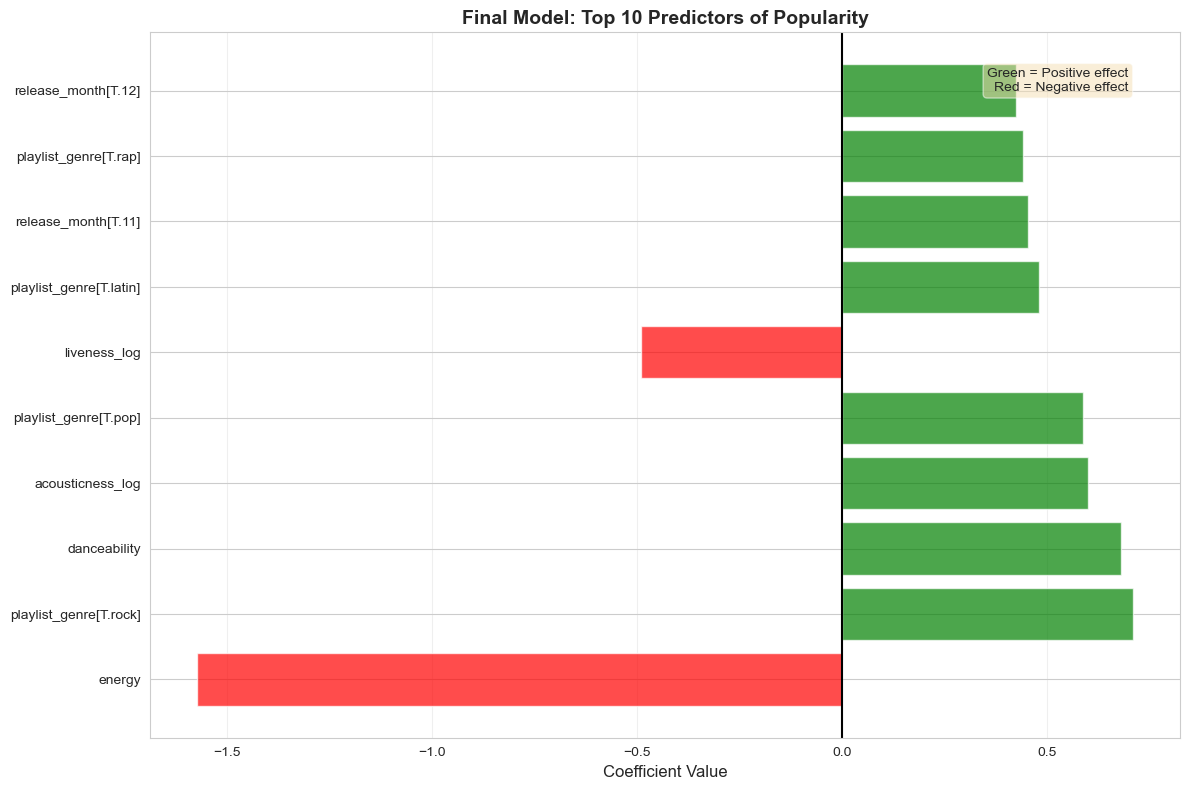

In [22]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

top_10 = final_sig_coefs.head(10)
colors = ['red' if val < 0 else 'green' for val in top_10['coef_value']]

ax.barh(range(len(top_10)), top_10['coef_value'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['original_name'].fillna(top_10['coef_name']))
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title('Final Model: Top 10 Predictors of Popularity', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=1.5)
ax.grid(alpha=0.3, axis='x')

# Add interpretation text
ax.text(0.95, 0.95, 
        'Green = Positive effect\nRed = Negative effect',
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### Predictive Trends

In [23]:
# Create prediction grid for visualization
input_grid = pd.DataFrame([
    (x01, x02, x03, x05, x06, x07, x08, x09, x10, x11, x12, x13, x14, x15, x16)
    for x01 in lm_df['x01'].unique()  # All genres
    for x02 in [lm_df['x02'].mode()[0]]  # Most common key
    for x03 in [lm_df['x03'].mode()[0]]  # Most common mode
    for x05 in [lm_df['x05'].mode()[0]]  # Most common month
    for x06 in [lm_df['x06'].mode()[0]]  # Most common decade
    for x07 in np.linspace(lm_df['x07'].min(), lm_df['x07'].max(), 5)  # Danceability range
    for x08 in np.linspace(lm_df['x08'].min(), lm_df['x08'].max(), 101)  # Energy range (most important)
    for x09 in [lm_df['x09'].mean()]
    for x10 in [lm_df['x10'].mean()]
    for x11 in [lm_df['x11'].mean()]
    for x12 in [lm_df['x12'].mean()]
    for x13 in [lm_df['x13'].median()]
    for x14 in [lm_df['x14'].median()]
    for x15 in [lm_df['x15'].mean()]
    for x16 in [lm_df['x16'].median()]
], columns=['x01', 'x02', 'x03', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10', 'x11', 
            'x12', 'x13', 'x14', 'x15', 'x16'])

# Generate predictions
input_grid['prediction'] = final_model.predict(input_grid)

# Get prediction intervals
pred_summary = final_model.get_prediction(input_grid).summary_frame()

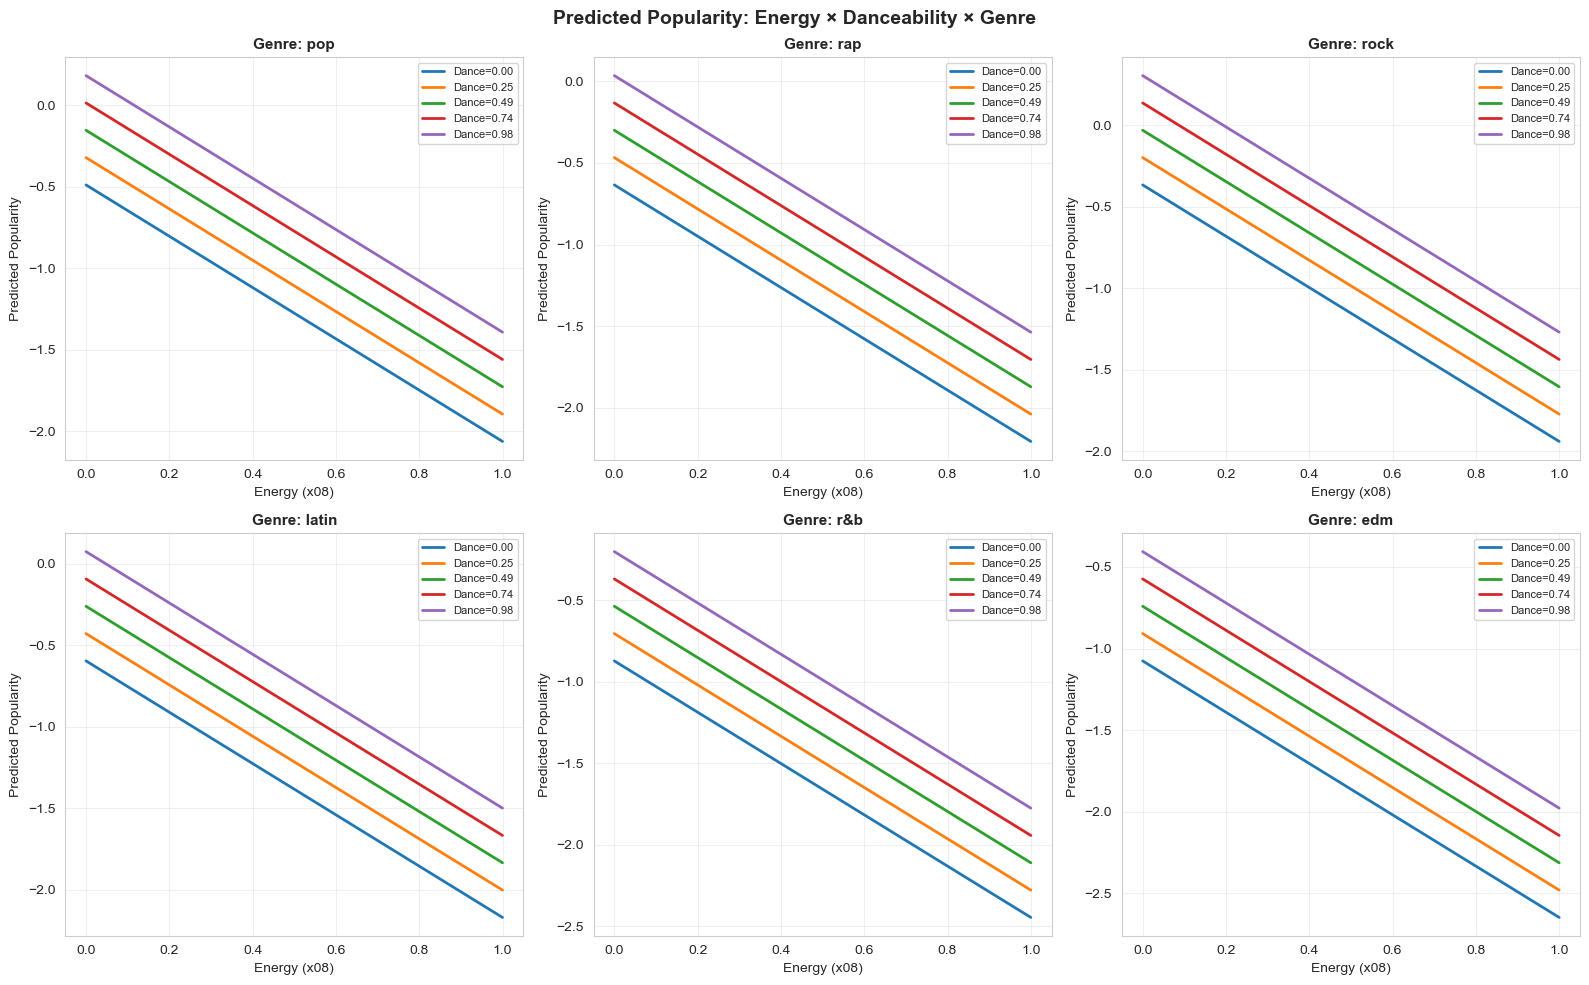

In [24]:
# Plot: Energy vs Popularity by Genre and Danceability
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

genres = input_grid['x01'].unique()

for idx, genre in enumerate(genres):
    genre_data = input_grid[input_grid['x01'] == genre]
    
    for dance_val in genre_data['x07'].unique():
        subset = genre_data[genre_data['x07'] == dance_val]
        axes[idx].plot(
            subset['x08'], 
            subset['prediction'],
            label=f'Dance={dance_val:.2f}',
            linewidth=2
        )
    
    # Map genre code back to name
    genre_name = col_map[col_map['model_name'] == 'x01']['original_name'].iloc[0]
    axes[idx].set_title(f'Genre: {genre}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Energy (x08)', fontsize=10)
    axes[idx].set_ylabel('Predicted Popularity', fontsize=10)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Predicted Popularity: Energy × Danceability × Genre', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Key Insight:**
- **Negative energy effect is consistent** across all genres and danceability levels
- **Genre shifts the intercept** but doesn't change the slope
- **Danceability has small positive effect** (higher lines = higher danceability)
- Rock/Pop/Rap consistently predicted higher than EDM/R&B


## Final Results

### Model Performance Summary

In [25]:
# Create comprehensive results table
results_summary = pd.DataFrame({
    'Model': ['Baseline', 'Categorical', 'Continuous', 'All Linear', 
              'Continuous²', 'All²', 'Derived Feat', 'Complex'],
    'Coefficients': ols_results_df['num_coefs'].values,
    'R² (Train)': ols_results_df['R_squared'].values,
    'RMSE (Train)': ols_results_df['RMSE'].values
})

# Add CV results
cv_means = cv_results_df.groupby('model_id')['R_squared'].mean()
results_summary['R² (CV)'] = results_summary.index.map(
    lambda i: cv_means.get(i+1, np.nan)
)

print("Complete Model Performance Summary:")
print(results_summary.to_string(index=False))

print("\n" + "="*80)
print("FINAL MODEL SELECTED: Model 4 (All Linear Additive)")
print("="*80)
print(f"Training R²:        0.0787")
print(f"CV R²:              0.0740 ± 0.0122")
print(f"Coefficients:       46")
print(f"Significant vars:   26")
print("="*80)

Complete Model Performance Summary:
       Model  Coefficients    R² (Train)  RMSE (Train)       R² (CV)
    Baseline             1 -3.552714e-15      2.241979 -2.356816e-04
 Categorical            36  4.972506e-02      2.185527  4.626654e-02
  Continuous            11  4.080772e-02      2.195757  3.940689e-02
  All Linear            46  7.867312e-02      2.151981  7.399855e-02
 Continuous²            56  5.183898e-02      2.183094           NaN
        All²           895  1.459888e-01      2.071874 -1.259021e+21
Derived Feat            52  7.982974e-02      2.150629  7.455639e-02
     Complex           101  8.919226e-02      2.139660  7.970144e-02

FINAL MODEL SELECTED: Model 4 (All Linear Additive)
Training R²:        0.0787
CV R²:              0.0740 ± 0.0122
Coefficients:       46
Significant vars:   26


## Conclusions

### What We Learned

**1. Predictive Power is Very Limited:**
- Best model explains only **7.4% of variance** in song popularity
- 92.6% of popularity variation is unexplained by audio features
- This is consistent across all modeling approaches tested

**2. Most Important Audio Features:**
- ⬇️ **Energy** (-1.57): Higher energy songs are LESS popular
- ⬆️ **Danceability** (+0.68): More danceable songs are MORE popular  
- ⬆️ **Acousticness** (+0.60): Acoustic elements increase popularity
- ⬇️ **Instrumentalness** (-0.41): Vocal tracks are more popular

**3. Categorical Influences:**
- **Genre matters**: Rock > Pop > Rap/Latin > R&B > EDM
- **Release timing**: November/December releases slightly more popular
- **Decade**: Minimal effect when controlling for audio features

**4. Why Audio Features Fail to Predict:**
Audio features capture *how a song sounds* but miss critical factors:
- **Artist fame/reputation** - Drake vs unknown artist
- **Marketing investment** - Radio play, playlist promotion
- **Algorithmic boosting** - Spotify's recommendation system
- **Cultural timing** - Right song at right moment
- **Network effects** - Viral spread, social media trends

**5. Model Complexity vs Performance:**
- Simple linear model (46 coefs) performs nearly as well as complex model (101 coefs)
- Overfitting is easy (Model 6: 895 coefs, R²=0.146 train, catastrophic CV failure)
- Parsimony wins: Model 4 is best balance of interpretability and performance

### Implications for Music Industry

**For Artists:**
- Audio production quality alone won't guarantee popularity
- Focus on marketing, audience building, timing

**For Researchers:**
- Need external data: artist metrics, marketing spend, playlist features
- Consider time-series modeling (how popularity evolves post-release)
- Classification approach (popular vs unpopular) might work better

**For Data Scientists:**
- Audio features are useful for *similarity/recommendation*, not *popularity prediction*
- External factors dominate the popularity equation

## Future Work

**Potential Improvements:**

1. **Feature Engineering:**
   - Interaction with artist follower count
   - Time since release
   - Playlist feature counts (how many playlists contain the song)

2. **Alternative Modeling:**
   - Classification: Predict "hit" vs "non-hit" (>80th percentile)
   - Random Forest / Gradient Boosting (capture non-linearities)
   - Neural networks (if sufficient external data available)

3. **Regularization:**
   - Elastic Net on Model 6 to reduce overfitting
   - Lasso to perform feature selection

4. **External Data Sources:**
   - Artist Spotify follower counts
   - Social media mentions
   - Radio airplay data
   - Music blog coverage

## Export Final Model

In [26]:
# Save model coefficients for reference
final_coefs = pd.DataFrame({
    'feature': final_model.params.index,
    'coefficient': final_model.params.values,
    'p_value': final_model.pvalues.values
})

# Map to original names
final_coefs['original_name'] = final_coefs['feature'].map(
    dict(zip(col_map['model_name'], col_map['original_name']))
)

final_coefs.to_csv('../data/final_model_coefficients.csv', index=False)
print("✓ Model coefficients exported")

print("\n" + "="*80)
print("PROJECT COMPLETE")
print("="*80)
print("Key Takeaway: Audio features alone explain only 7.4% of song popularity.")
print("External factors (artist fame, marketing, algorithms) likely dominate.")
print("="*80)

✓ Model coefficients exported

PROJECT COMPLETE
Key Takeaway: Audio features alone explain only 7.4% of song popularity.
External factors (artist fame, marketing, algorithms) likely dominate.
